# Forecasting a timeseries

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
path = Path('CTA_-_Ridership_-_Daily_Boarding_Totals_20250901.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months 

df.dtypes

day_type    object
bus         object
rail        object
dtype: object

## Convert Bus and Rail into numeric data

In [3]:
df["bus"] = df["bus"].astype(str).str.replace(",", "").astype(int)
df["rail"] = df["rail"].astype(str).str.replace(",", "").astype(int)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


## W - means weekdays , A - Saturday, U - Sunday

In [5]:
df.tail()

,day_type,bus,rail
date,,,
2025-06-26,W,561301,471300
2025-06-27,W,543140,416639
2025-06-28,A,427366,337560
2025-06-29,U,316118,323242
2025-06-30,W,534839,376363


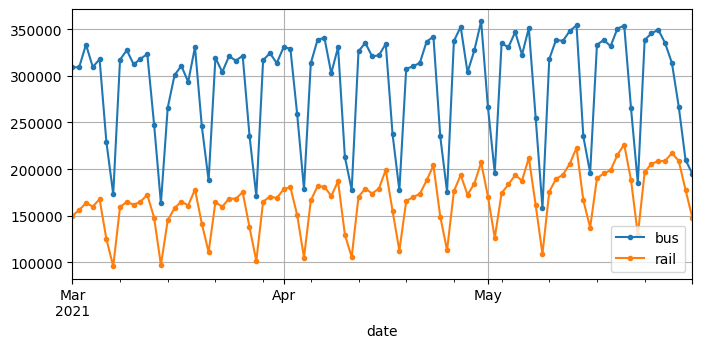

In [6]:
df.loc["2021-03":"2021-05"].plot(grid=True, marker='.', figsize=(8,3.5))
plt.show()

# Naive Forecasting

---
The naive forecasting is adopting the current/previous day, week, month data to forecast the next day, week, or month. This can serve as a baseline forecast.

From the graph below, we use the previous 7 days to forecast the next 7 days for the period of March to May 2021 and it was very close in its predictions.

---

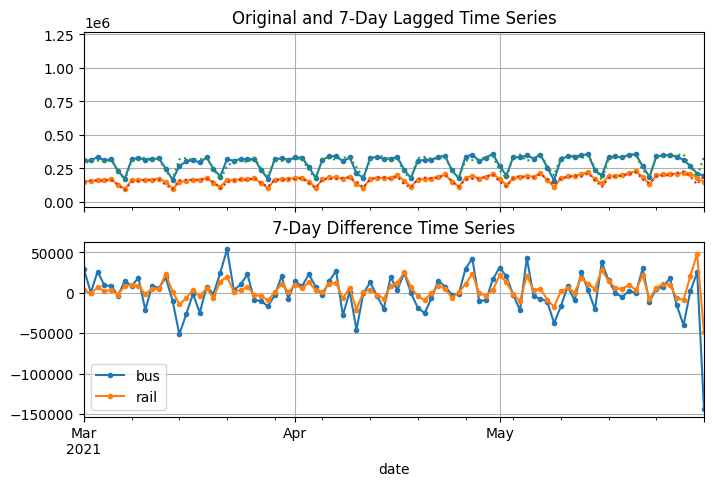

In [7]:
diff_7 = df[['bus', 'rail']].diff(7)["2021-03":"2021-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
axs[0].set_title("Original and 7-Day Lagged Time Series")


df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[1].set_title("7-Day Difference Time Series")

plt.show()

### Lets get the Mean Absolute Error for the period

In [8]:
diff_7.abs().mean()

bus     16737.826087
rail     9014.217391
dtype: float64

### Get the Mean Abssolute Percentage Error (MAPE) 

In [9]:
targets = df[['bus', 'rail']]["2021-03":"2021-05"]
(diff_7/targets).abs().mean()

bus     0.063122
rail    0.055540
dtype: float64

---
We can notice that the bus has a better MAE but worse MAPE than that of rail, however, the MAPE is very close for both bus and rail compared to the MAE.

This is because bus ridership are larger hence their forecast error will also be larger. But the percentage error will put things in the proper perspective.

MAPE : 
bus - 6.3% ; 
rail - 5.6%

---

### Yearly Seasonality - 2001 to 2023

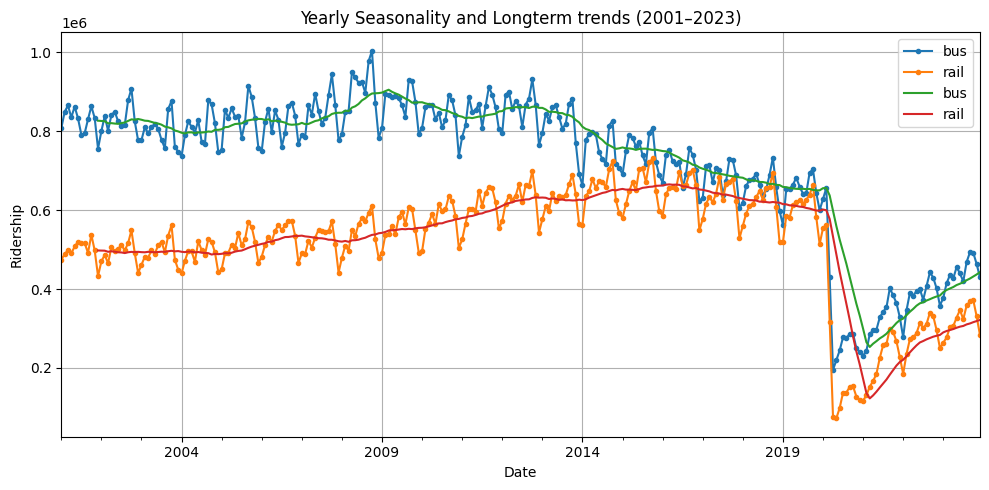

In [10]:
period = slice("2001", "2023") 

# Select only numeric columns
df_numeric = df[["bus", "rail"]]

# Resample monthly and compute mean
df_monthly = df_numeric.resample('M').mean()

# 12-month rolling average
rolling_average_12_months = df_monthly["2001":"2023"].rolling(window=12).mean()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
df_monthly["2001":"2023"].plot(ax=ax, marker=".", label="Monthly Mean")
rolling_average_12_months.plot(ax=ax, grid=True, label="12-Month Rolling Avg")
ax.set_title("Yearly Seasonality and Longterm trends (2001–2023)")
ax.set_xlabel("Date")
ax.set_ylabel("Ridership")
ax.legend()
plt.tight_layout()
plt.show()


### The 12-Months difference

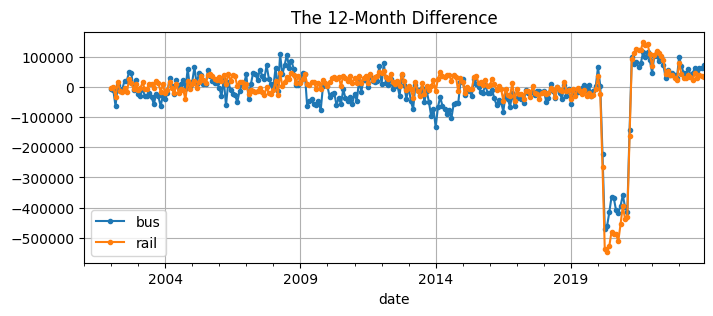

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.gca().set_title("The 12-Month Difference")
plt.show()

---
The difference removed the yearly seasonality forecast except for the year 2020 which is the period of COVID/Lock Down

---

# ARMA MODELS - autoregressive moving average model

---
## What ARMA stands for

ARMA = AutoRegressive Moving Average.
It’s a statistical model used to predict future values of a time series (like stock prices, temperature, or ridership) based on its past behavior.

It has two parts:

- AR (AutoRegressive) – uses past values of the series itself.

- MA (Moving Average) – uses past “errors” or shocks (differences between actual and predicted values).

## AutoRegressive (AR) part

- Think of it like this: the future value depends on some number of past values.

- Example: today’s temperature might depend on yesterday’s temperature and the day before.

- We call the number of past values we use p, the “order” of the AR part.

$$
X_t = c + \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + error
$$

$$
\begin{aligned}
\text{Where:} \\
X_t &= \text{value at time } t \\
c &= \text{constant term} \\
\phi_1, \phi_2, \dots, \phi_p &= \text{coefficients (how much past values influence the current value)} \\
\text{error} &= \text{random noise}
\end{aligned}
$$

## Moving Average (MA) part

This part looks at past errors instead of past values.

Why? Sometimes patterns are not obvious from past values alone, but the mistakes we made in predicting before can help forecast future values.

We call the number of past errors we include q, the “order” of the MA part.

$$
\begin{aligned}
X_t &= c + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} \\[1mm]
\text{Where:} \\
\theta_1, \theta_2, \dots, \theta_q &= \text{coefficients for past errors} \\
\epsilon_t &= \text{random noise at time } t
\end{aligned}
$$

## ARMA combines both

An ARMA(p, q) model uses both: p past values (AR) q past errors (MA)

$$
\begin{aligned}
X_t &= c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} \\[1mm]
\text{Where:} \\
X_t &= \text{value at time } t \\
c &= \text{constant term} \\
\phi_1, \phi_2, \dots, \phi_p &= \text{coefficients for past values (AR part)} \\
\theta_1, \theta_2, \dots, \theta_q &= \text{coefficients for past errors (MA part)} \\
\epsilon_t &= \text{random noise at time } t
\end{aligned}
$$

## Key points to remember

Stationarity: ARMA works best when the data fluctuates around a constant mean and variance over time. If the series trends upwards or grows, we usually difference it first (leading to ARIMA).

p and q: These are the “orders” you choose based on patterns in the data (autocorrelation and partial autocorrelation plots help).

Error term: Random noise in your data that you can’t predict.

## Intuition / Example

Imagine you’re forecasting daily bus ridership:

AR part: “Ridership today is probably similar to yesterday and the day before.”

MA part: “Yesterday we overpredicted by 500 passengers, so maybe today will be slightly lower to compensate.”

Combine both, and ARMA gives a formula that weighs past ridership and past mistakes to make the best estimate for today.

## This model assumes stationarity  of the series

---

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [13]:
origin, today = "2022-01-01", "2022-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [14]:
print(y_pred)

2022-06-01    317978.011086
Freq: D, dtype: float64
